# **Example of CNN**
https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html



A typical training procedure for feed-forward network is as follows:

* Define the neural network that has some learnable parameters (or weights)
* Iterate over a dataset of inputs
* Process input through the network
* Compute the loss (how far is the output from being correct)
* Propagate gradients back into the network’s parameters
* Update the weights of the network, typically using a simple update rule: weight = weight - learning_rate * gradient
  
## **NOTE**
**torch.nn** only supports mini-batches. The entire torch.nn package only supports inputs that are a mini-batch of samples, and not a single sample. If you have a single sample, just use input.unsqueeze(0) to add a fake batch dimension.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Conv2d

#TODO: hay que hacer alguna importacion extra para que muestre todo el docstring de torch 

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution kernel
        self.conv1 = Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        
        #NOTE: image dimension at this point is 5x5 because the input size is 32x32 and when going
        # through conv1 it remains 28x28, then max_pool2d(2x2) is applied leaving 14x14 which is
        # the input size for conv2 and therefore, the outputs are 10x10 and when applying 
        # a max_pool2d(2x2) the output is 5x5.
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    # You just have to define the forward function, and the backward function (where gradients are computed) is automatically defined for you using autograd.
    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        # flatten all dimensions except the batch dimension
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [2]:
params = list(net.parameters())
print(len(params))
print(params[0].size()) 

10
torch.Size([6, 1, 5, 5])


Let’s try a random 32x32 input. Note: expected input size of this net (LeNet) is 32x32. To use this net on the MNIST dataset, please resize the images from the dataset to 32x32.

In [3]:
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)

tensor([[-0.1050, -0.0165,  0.0537,  0.0063,  0.0666, -0.0453,  0.0375, -0.0171,
         -0.0466,  0.0339]], grad_fn=<AddmmBackward0>)


In [6]:
# examine the output of the first convolutional layer 
out = net.conv1(input)
print(out.size())

torch.Size([1, 6, 28, 28])


In [8]:
output = net(input)
target = torch.randn(10)  # a dummy target, for example
target = target.view(1, -1)  # make it the same shape as output
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

tensor(1.1056, grad_fn=<MseLossBackward0>)


To backpropagate the error all we have to do is to loss.backward(). You need to clear the existing gradients though, else gradients will be accumulated to existing gradients.

In [14]:
net.zero_grad()     # zeroes the gradient buffers of all parameters

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
None
conv1.bias.grad after backward
tensor([-0.0001, -0.0122,  0.0168, -0.0023,  0.0123,  0.0020])


Update the weights

In [15]:
# We can implement this using simple Python code

learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate)

In [ ]:
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()    # Does the update

# **TRANSFER LEARNING FOR COMPUTER VISION TUTORIAL**
https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#transfer-learning-for-computer-vision-tutorial

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

# si las entradas a la DNN no cambian de un batch a otro, la optimización puede ser beneficiosa.
cudnn.benchmark = True 

plt.ion()   # interactive mode

## Load Data
We will use torchvision and torch.utils.data packages for loading the data.

In [ ]:
%%bash
wget -O DATA/hymenoptera_data.zip https://download.pytorch.org/tutorial/hymenoptera_data.zip
unzip DATA/hymenoptera_data.zip -d DATA

In [9]:
# Data augmentation and normalization for training
# Just normalization for validation

data_dir = 'DATA/hymenoptera_data'

data_transforms = {
    'train': transforms.Compose([
        # Recorta y redimensiona aleatoriamente la imagen 224x224
        transforms.RandomResizedCrop(224),

        # Volteo horizontal aleatorio con una probabilidad de 0.5.
        transforms.RandomHorizontalFlip(),

        # Convierte la imagen a un tensor de PyTorch.
        transforms.ToTensor(),

        # Normaliza la imagen con media y desviación estándar predefinidas.
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

    'val': transforms.Compose([
        # Redimensiona la imagen a una altura de 256 píxeles manteniendo la proporción original.
        transforms.Resize(256),

        #  Recorta la imagen al centro con una resolución de 224x224
        transforms.CenterCrop(224),

        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=4)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
class_names,dataset_sizes

(['ants', 'bees'], {'train': 245, 'val': 153})

## Visualize a few images

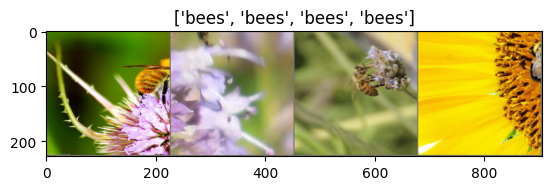

In [4]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Training the model using: 
- Scheduling the learning rate
- Saving the best model

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(
            f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

## Visualizing the model predictions
Generic function to display predictions for a few images

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetuning the ConvNet

In [7]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features

# replace the fully conected layer( in this case, its has only one)
model_ft.fc = nn.Linear(num_ftrs,len(class_names) )

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## Train and evaluate


In [11]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5238 Acc: 0.7102
val Loss: 0.2059 Acc: 0.9412

Epoch 1/24
----------
train Loss: 0.5720 Acc: 0.7714
val Loss: 0.3231 Acc: 0.8889

Epoch 2/24
----------
train Loss: 0.6253 Acc: 0.7469
val Loss: 0.3886 Acc: 0.8889

Epoch 3/24
----------
train Loss: 0.5695 Acc: 0.7918
val Loss: 0.2361 Acc: 0.9150

Epoch 4/24
----------
train Loss: 0.4478 Acc: 0.8041
val Loss: 0.2454 Acc: 0.9150

Epoch 5/24
----------
train Loss: 0.3642 Acc: 0.8041
val Loss: 0.2940 Acc: 0.8889

Epoch 6/24
----------
train Loss: 0.3657 Acc: 0.8653
val Loss: 0.3212 Acc: 0.9020

Epoch 7/24
----------
train Loss: 0.3986 Acc: 0.8694
val Loss: 0.2119 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.2796 Acc: 0.8980
val Loss: 0.2111 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.3246 Acc: 0.8531
val Loss: 0.2340 Acc: 0.9150

Epoch 10/24
----------
train Loss: 0.2813 Acc: 0.8694
val Loss: 0.2333 Acc: 0.9150

Epoch 11/24
----------
train Loss: 0.2790 Acc: 0.8816
val Loss: 0.2173 Acc: 0.9150

Ep

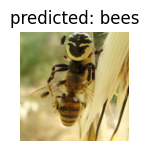

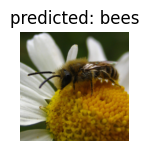

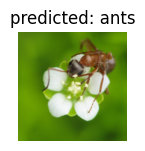

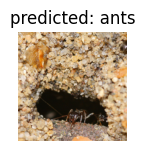

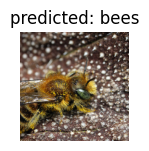

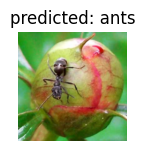

In [13]:
visualize_model(model_ft)

## ConvNet as fixed feature extractor
Here, we need to freeze all the network except the final layer. We need to set requires_grad = False to freeze the parameters so that the gradients are not computed in backward().

In [14]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [15]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6479 Acc: 0.6408
val Loss: 0.2029 Acc: 0.9412

Epoch 1/24
----------
train Loss: 0.5327 Acc: 0.7265
val Loss: 0.2257 Acc: 0.9281

Epoch 2/24
----------
train Loss: 0.4505 Acc: 0.7918
val Loss: 0.1889 Acc: 0.9281

Epoch 3/24
----------
train Loss: 0.4549 Acc: 0.7837
val Loss: 0.1980 Acc: 0.9346

Epoch 4/24
----------
train Loss: 0.4089 Acc: 0.8204
val Loss: 0.2291 Acc: 0.9281

Epoch 5/24
----------
train Loss: 0.3368 Acc: 0.8531
val Loss: 0.2167 Acc: 0.9346

Epoch 6/24
----------
train Loss: 0.5539 Acc: 0.7837
val Loss: 0.3681 Acc: 0.8758

Epoch 7/24
----------
train Loss: 0.4281 Acc: 0.8082
val Loss: 0.2051 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3063 Acc: 0.8857
val Loss: 0.1743 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3458 Acc: 0.8490
val Loss: 0.1913 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3663 Acc: 0.8327
val Loss: 0.1676 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3069 Acc: 0.8571
val Loss: 0.1591 Acc: 0.9542

Ep

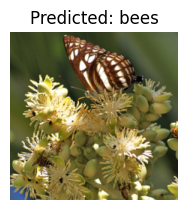

In [16]:
def visualize_model_predictions(model,img_path):
    """Inference on custom images"""
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0) # create a dimension of batch 
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)
 
       
visualize_model_predictions(
    model_conv,
    img_path='DATA/hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)

plt.ioff()
plt.show()